In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [3]:
class TSBModel:
    
    
    def __init__(self, alpha = .1, beta = .1):
        self.alpha = alpha
        self.beta = beta
        self.fitted = False
    
    def fit(self, x):
        
        def _tsb(params):
    
            alpha, beta = params

            x = self.data

            # serie della domanda
            demand = x.copy()
            demand.loc[demand == 0] = np.nan
            demand = demand.ffill()
            demand = demand.fillna(0)

            # serie di intervalli
            intervals = [1]
            for t in range(1, len(x)):
                if x[t-1] != 0:
                    intervals.append(1)
                else:
                    intervals.append(1 + intervals[t-1])
            intervals = np.array(intervals, dtype='float')

            # periodicity
            peridocity = 1/intervals


            # prima osservazione
            initial_obs = np.argmax(x != 0)
            smoothed_demand    = [demand[initial_obs]]
            smoothed_periodicity = [peridocity[0] if demand[0] != 0 else 0]

            # forecast placeholder
            fitted_values = [None]

            # exponential smoothing of demand and periodicity
            for t in range(len(x)):
                if x[t] == 0:
                    smoothed_demand.append(smoothed_demand[-1])

                    sp = (beta  * 0) + ((1-beta) * smoothed_periodicity[-1])
                    smoothed_periodicity.append(sp)


                else:
                    sd = (alpha * demand[t]) + ((1-alpha) * smoothed_demand[-1])
                    smoothed_demand.append(sd)

                    sp = (beta  * 1) + ((1-beta) * smoothed_periodicity[-1])
                    smoothed_periodicity.append(sp)

                if demand[t] > 0:
                    fitted_values.append(smoothed_demand[-1] * smoothed_periodicity[-1])
                else:
                    fitted_values.append(0)

            # forecast and fitted values
            fitted_values  = np.array(fitted_values, dtype = 'float')
            forecast = fitted_values[-1]
            fitted_values = fitted_values[:-1]

            # rmse
            error = x-fitted_values
            rmse = np.sqrt((error**2).mean())

            # save into object
            self.forecast = forecast
            self.fitted_values = fitted_values
            self.residuals = error
            self.rmse = rmse

            return rmse
    
        self.data = x
        fitted = minimize(_tsb, x0=[.1, .1], bounds=[(0, 1), (0, 1)])
        self.alpha = fitted.x[0]
        self.beta = fitted.x[1]
        self.fitted = True
        
        # last pass to store final optimal values
        _tsb([self.alpha, self.beta])
        
        return self
    
    def predict(self, h=10):
        return np.array([self.forecast]*h)

In [4]:
# load sample data
df = (
    pd.read_excel('data.xlsx')
    .set_index('date')
    .resample('M')
    .sum()
)

In [10]:
# fit model
model = TSBModel().fit(df['sales'])

print(f'Forecast: {model.forecast}')
print(f'Fitted alpha: {model.alpha}')
print(f'Fitted beta: {model.beta}')

Forecast: 0.5974256451942589
Fitted alpha: 0.0
Fitted beta: 0.17322741462632069


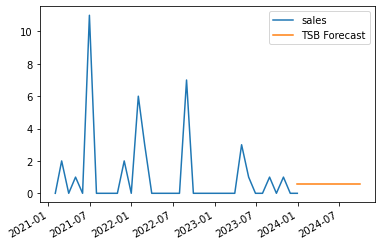

In [14]:
# forecast
horizon = 10
fcast_df = pd.DataFrame(index = pd.date_range(df.index[-1], periods=horizon, freq=df.index.freq))
fcast_df['TSB Forecast'] = model.forecast

# plot
pd.concat([df, fcast_df]).plot();